## DenseNet Model

In [42]:
###-----------------
### Import Libraries
###-----------------

import os

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf

    
%matplotlib inline

In [43]:
###------------------
### Memory Management
###------------------

physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [44]:
###---------------------------------------
### Global  parameters and Hyperparamaters
###---------------------------------------

inpDir = '/home/dai/directory_env/input' # location where input data is stored
outDir = '/home/dai/directory_env/output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '/home/dai/directory_env/models' # location to save model files
valDir = 'valid_flowers' # location related to this dataset
altName = 'dropout_bn_no_bias_leaky_flowers' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 100   # number of cycles to run

ALPHA = 0.01

BATCH_SIZE = 16

TEST_SIZE = 0.2

IMG_HEIGHT = 224

IMG_WIDTH = 224

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation 
ROTATION_FACTOR = (-0.1, 0.1) 

FILL_MODE = 'nearest'

ES_PATIENCE = 20 # if performance does not improve stop

LR_PATIENCE = 10 # if performace is not improving reduce alpha

LR_FACTOR = 0.5 # rate of reduction of alpha

RATE = 0.2


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,6),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [45]:

def fn_plot_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    # create figure and axis array
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    # take first axis
    ax = axes[0]

    # Plot Column 0 and 2 (Loss and validation loss)
    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    # get minimum values for plotting
    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords
    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # label the axes
    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    # grids make it look good
    ax.grid()
    
    # take second axis object
    ax = axes[1]

    # plot column 1 and 3 (accuracy and validation accuracy)
    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords
    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # label the axes
    ax.set_xlabel("Epochs")
    
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    # grids make it look good
    ax.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open images
    plt.show()

In [46]:
# Function to plot number of classes in training and testing sets
def fn_plot_label(tr_ds, ts_ds):
    
    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure
    plt.figure(figsize = (15,5))
    
    # create two subplots
    plt.subplot(1,2,1)

    # create array of training labels
    train_labels = tf.concat([y for x, y in tr_ds], axis = 0).numpy()
    
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(train_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.7)
    
    # add title
    plt.title('Training Set')
    
    # add ticks on axis
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()


    #pick second image
    plt.subplot(1,2,2)

    # create array of testing labels 
    val_labels = tf.concat([y for x, y in ts_ds], axis = 0).numpy()
    
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(val_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.7)
    
    # add title
    plt.title('Test Set')
    
    # add ticks
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open figures
    plt.show()

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [47]:
'''
    For reading from web link
'''

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                  fname='flower_photos',
                                  untar=True)
data_dir = pathlib.Path(data_dir)
'''
#     For reading from local directory
# '''
# data_dir = os.path.join(inpDir, subDir)

'\n#     For reading from local directory\n# '

In [48]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [49]:
#list content of data_dir
os.listdir(data_dir)

['sunflowers', 'dandelion', 'LICENSE.txt', 'roses', 'daisy', 'tulips']

In [50]:
data_dir= '/root/.keras/datasets/flower_photos'

### Train and Test Datasets

In [51]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Is it picking the class names?

In [52]:
class_names = train_ds.class_names
print('total ', len(class_names), class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [53]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Verify the data

To verify that the dataset looks correct, let's plot the first batch from the training set and display the class name below each image.


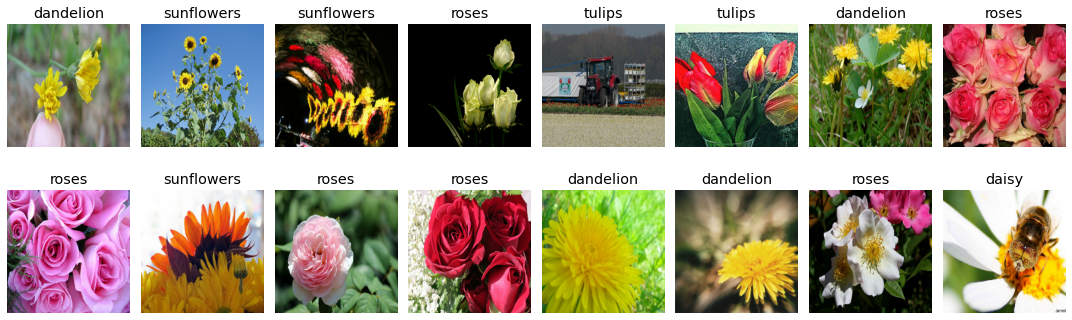

In [54]:
# set figure size
plt.figure(figsize=(15,5))

# take one batch of the dataset
for images, labels in train_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        plt.subplot(int(BATCH_SIZE/8), 8, i+1 )
        
        # switch off the grids
        plt.grid(False)
        
        # image_size may have converted these images to float
        plt.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        plt.title(class_names[labels[i]])
        
        # no axis
        plt.axis("off")
        
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
# display all open images    
plt.show()

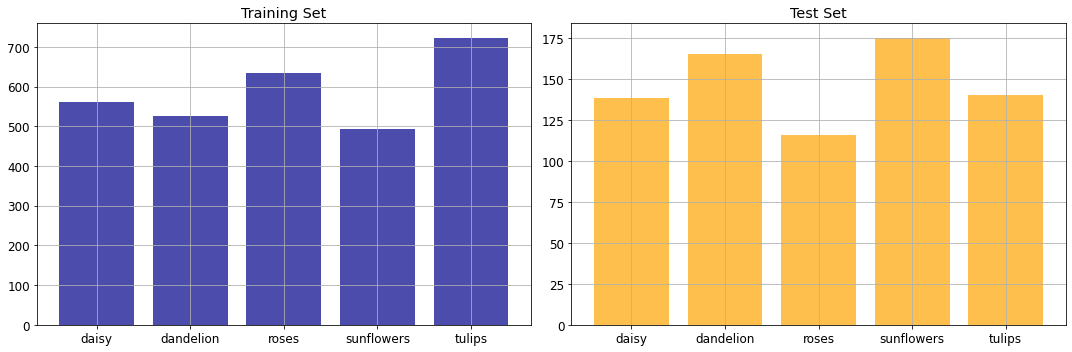

In [55]:
# how many examples in each of the class
fn_plot_label(train_ds, test_ds)

In [56]:
# pick the input_shape 

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

## RandomZoom

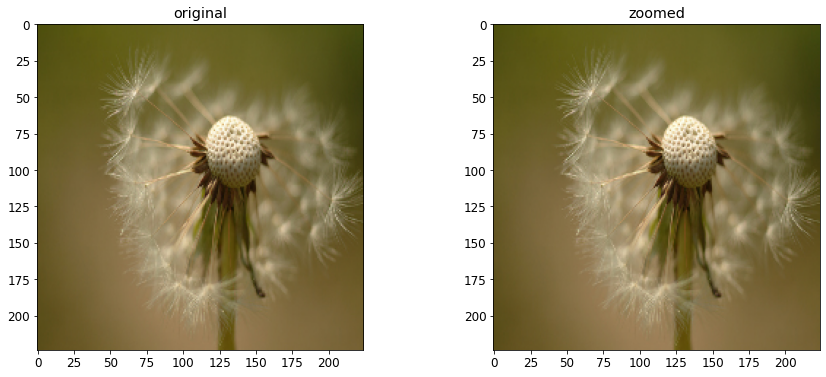

In [57]:
layer = tf.keras.layers.RandomZoom(height_factor=(-0.2,-0.2),
                                   width_factor=(-0.2,-0.2)
                                  )

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('zoomed')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))
 

## Random Rotation

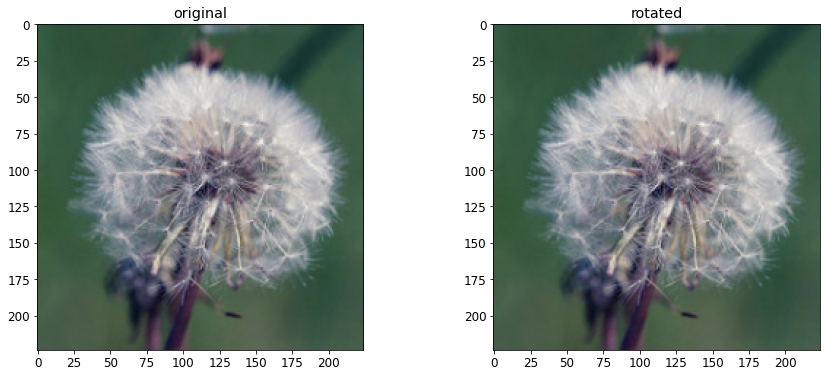

In [58]:
layer = tf.keras.layers.RandomRotation((-0.5, 0.5),
                                       fill_mode='nearest')

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('rotated')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

### Standardize the data
The original RGB channel values are in the [0, 255] range. Resizing has converted those values into floats. Standardize values to be in the [0, 1] range by using the tf.keras.layers.experimental.preprocessing.Rescaling layer.

In [59]:
## Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# DenseNet Model 

![image.png](attachment:image.png)

In [60]:
densenet_model = tf.keras.applications.densenet.DenseNet169(
    include_top=False,
    weights='imagenet',
    input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]
)

In [61]:
for layer in densenet_model.layers:
    layer.trainable = False

# Early Stopping


In [62]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=ES_PATIENCE,
                                                  verbose=1)

# Kernel Initializer

In [63]:
krnl_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

In [64]:
model = tf.keras.models.Sequential() # Sequential Model Initialization

model.add(tf.keras.layers.Rescaling(1. / 255.)) # scaling all images between 0 - 1

model.add(densenet_model) # added the DenseNet to our model





model.add(tf.keras.layers.Flatten()) # Flattening layer

# Dense Layer 1
model.add(tf.keras.layers.Dense(1664, 
                                kernel_initializer = krnl_init,
                                #kernel_regularizer=REGULAR,
                                #activation=D_ACTIVATION
                                ))


# model.add(tf.keras.regularizers.L2(l2=0.02)) # added Regularization

model.add(tf.keras.layers.BatchNormalization()) # Batch Normalization

model.add(tf.keras.layers.Activation("relu")) # Added activation function

model.add(tf.keras.layers.Dropout(0.3)) # Added DropOut 

model.add(tf.keras.layers.Dense(5)) # Output Layer



In [65]:
densenet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                       

### Model Compile

In [66]:
model.compile(optimizer='adam',
                       loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'],
)

### Fitting the Model on data

In [67]:
history = model.fit(train_ds,
                             validation_data=test_ds
                             ,batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks= [early_callback],
                             verbose=2)

Epoch 1/100
184/184 - 48s - loss: 0.7169 - accuracy: 0.8188 - val_loss: 0.4889 - val_accuracy: 0.8774 - 48s/epoch - 260ms/step
Epoch 2/100
184/184 - 20s - loss: 0.0651 - accuracy: 0.9799 - val_loss: 0.3411 - val_accuracy: 0.9114 - 20s/epoch - 106ms/step
Epoch 3/100
184/184 - 19s - loss: 0.0131 - accuracy: 0.9983 - val_loss: 0.3151 - val_accuracy: 0.9169 - 19s/epoch - 106ms/step
Epoch 4/100
184/184 - 19s - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.3321 - val_accuracy: 0.9183 - 19s/epoch - 103ms/step
Epoch 5/100
184/184 - 19s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3242 - val_accuracy: 0.9128 - 19s/epoch - 103ms/step
Epoch 6/100
184/184 - 19s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3256 - val_accuracy: 0.9142 - 19s/epoch - 103ms/step
Epoch 7/100
184/184 - 19s - loss: 7.4152e-04 - accuracy: 1.0000 - val_loss: 0.3265 - val_accuracy: 0.9183 - 19s/epoch - 103ms/step
Epoch 8/100
184/184 - 19s - loss: 5.8963e-04 - accuracy: 1.0000 - val_loss: 0.3345 - val_accuracy: 0.9183 -

In [68]:
res_df = pd.DataFrame(history.history)
res_df

,loss,accuracy,val_loss,val_accuracy
0,0.716904,0.818801,0.488865,0.877384
1,0.065130,0.979905,0.341114,0.911444
2,0.013056,0.998297,0.315101,0.916894
3,0.003145,0.999659,0.332065,0.918256
4,0.001681,1.000000,0.324155,0.912807
5,0.001063,1.000000,0.325562,0.914169
6,0.000742,1.000000,0.326495,0.918256
7,0.000590,1.000000,0.334541,0.918256
8,0.000445,1.000000,0.335114,0.918256
9,0.000402,1.000000,0.337579,0.919619


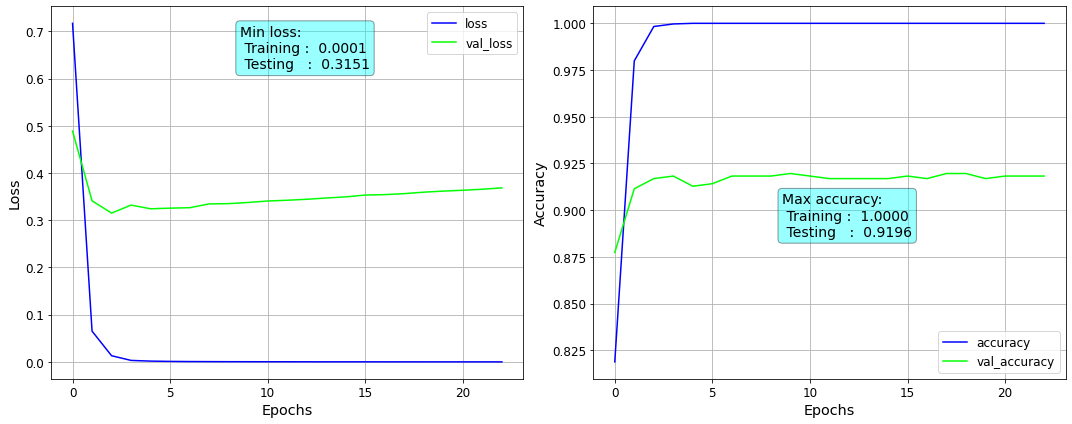

In [69]:

fn_plot_hist(res_df)